
# Retina Disease Classification using Convolutional Neural Networks (CNN)

## Medical Image Classification Case Study

This notebook presents an **end-to-end deep learning workflow** for classifying retinal diseases
using fundus images. The project aims to demonstrate how convolutional neural networks (CNN)
can assist in **early detection of eye diseases**, supporting clinical decision-making.

**Objective:**  
Build an image classification model capable of identifying retinal disease categories
from fundus images using deep learning techniques.


# Retina Disease Classification (Cataract Detection)
**Domain:** Computer Vision / Medical AI

**Tech Stack:** Python, PyTorch/TensorFlow, OpenCV, CNN

## Project Overview
Cataract is a leading cause of blindness globally. Early detection through automated screening can significantly improve patient outcomes. This project aims to build a **Convolutional Neural Network (CNN)** to classify retinal fundus images into **'Cataract'** or **'Normal'** categories. Dataset used for this project obtained from Kaggle.

##  Objectives
1. **Data Indexing & Quality Control Pipeline**: Performs automated scanning and cleaning of the raw image dataset to ensure data integrity before model training.
2.  **Data Preprocessing:** Apply advanced image processing techniques (CLAHE, Resizing) to handle varying lighting conditions in medical images.
2.  **Data Augmentation:** Implement geometric transformations to address dataset imbalance.
3.  **Modeling:** Train a Deep Learning model to accurately detect cataract symptoms.
4.  **Evaluation:** Analyze model performance using Confusion Matrix and Accuracy metrics.

---

In [ ]:
! pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Bukitvista/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
! kaggle datasets download gunavenkatdoddi/eye-diseases-classification

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0
 97% 716M/736M [00:11<00:00, 86.3MB/s]
100% 736M/736M [00:11<00:00, 68.7MB/s]


In [ ]:
! unzip eye-diseases-classification.zip

Archive:  eye-diseases-classification.zip
  inflating: dataset/cataract/0_left.jpg  
  inflating: dataset/cataract/103_left.jpg  
  inflating: dataset/cataract/1062_right.jpg  
  inflating: dataset/cataract/1083_left.jpg  
  inflating: dataset/cataract/1084_right.jpg  
  inflating: dataset/cataract/1102_left.jpg  
  inflating: dataset/cataract/1102_right.jpg  
  inflating: dataset/cataract/1115_left.jpg  
  inflating: dataset/cataract/1126_right.jpg  
  inflating: dataset/cataract/112_right.jpg  
  inflating: dataset/cataract/1144_left.jpg  
  inflating: dataset/cataract/1144_right.jpg  
  inflating: dataset/cataract/1164_left.jpg  
  inflating: dataset/cataract/1167_right.jpg  
  inflating: dataset/cataract/119_left.jpg  
  inflating: dataset/cataract/1285_left.jpg  
  inflating: dataset/cataract/1415_left.jpg  
  inflating: dataset/cataract/1415_right.jpg  
  inflating: dataset/cataract/1435_left.jpg  
  inflating: dataset/cataract/1444_left.jpg  
  inflating: dataset/cataract/1452_l

In [ ]:
!pip install path

In [ ]:
from pathlib import Path

BASE_DIR = Path("/content/dataset")
RAW_DIR = BASE_DIR/"rawdata"
OUT_DIR = BASE_DIR/"work"
RAW_DIR.mkdir(parents=True, exist_ok = False)
OUT_DIR.mkdir(parents=True, exist_ok = False)


In [ ]:
!pip install imagehash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 12.8 MB/s eta 0:00:00


## Data Indexing & Quality Control Pipeline

This module performs automated scanning and cleaning of the raw image dataset to ensure data integrity before model training.

### Key Processes:
1.  **Integrity Check:** Verifies file headers and valid image extensions (`.jpg`, `.png`, etc.) using `imghdr` and `cv2`.
2.  **Metadata Extraction:**
    * **MD5 Checksum:** Generates unique hashes to detect and remove exact duplicates.
    * **Laplacian Variance:** Measures image sharpness to identify and filter out blurry images.
    * **Brightness & RGB Stats:** Calculates pixel intensity statistics to detect extreme outliers (too dark/bright).
3.  **Data Cleaning:**
    * Removes corrupt files.
    * Drops duplicate images based on MD5 hashes.
    * Filters out outliers (1% blurriest, 1% darkest/brightest) to stabilize training.

###  Outputs:
* `image_index_raw.csv`: Full metadata of all scanned files.
* `image_index_clean.csv`: Curated dataset list ready for training.

---

In [ ]:
import os, hashlib, imghdr
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image, ImageOps, UnidentifiedImageError
import cv2
import imagehash
from tqdm import tqdm

RAW_DIR = Path("/content/dataset")
OUT_DIR = Path("/content/dataset/work")
OUT_DIR.mkdir(parents=True, exist_ok=True)

EXT_VALID_GAMBAR = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def md5sum(p: Path, chunk: int = 65536) -> str | None:
    """MD5 checksum yang aman untuk file besar."""
    try:
        h = hashlib.md5()
        with open(p, 'rb') as f:
            for b in iter(lambda: f.read(chunk), b''):
                h.update(b)
        return h.hexdigest()
    except Exception:
        return None

def aman(path: Path) -> Image.Image:
    """Buka gambar dengan aman + perbaiki orientasi EXIF."""
    img = Image.open(path)
    img = ImageOps.exif_transpose(img)
    img.load()
    return img

rows = []

classes = [d.name for d in RAW_DIR.iterdir() if d.is_dir()]

for cls in sorted(classes):
    files = [
        p for p in (RAW_DIR / cls).rglob('*')
        if p.is_file() and p.suffix.lower() in EXT_VALID_GAMBAR
    ]

    for p in tqdm(files, desc=f"scan {cls}"):
        ok = True
        w = h = None
        mode = None

        try:
            fsize = p.stat().st_size
        except Exception:
            fsize = None


        ext_ok = (imghdr.what(p) is not None)

        try:
            pil_img = aman(p)
            w, h = pil_img.size
            mode = pil_img.mode

            img = cv2.imread(str(p))
            if img is None:
                ok = False
                lap_var = mean_b = std_b = None
                r_mean = g_mean = b_mean = None
            else:
                gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                lap_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())
                mean_b = float(gray.mean())
                std_b = float(gray.std())

                b, g, r = img.mean(axis=(0, 1))
                r_mean, g_mean, b_mean = float(r), float(g), float(b)

        except (UnidentifiedImageError, OSError):
            ok = False
            lap_var = mean_b = std_b = None
            r_mean = g_mean = b_mean = None

        phash = None
        if ok and ext_ok:
            try:
                phash = str(imagehash.phash(aman(p).convert("RGB")))
            except Exception:
                pass

        rows.append({
            "filepath": str(p),
            "class": cls,
            "ok_image": bool(ok and ext_ok),
            "width": w,
            "height": h,
            "aspect_ratio": (float(w) / float(h) if (w and h) else None),
            "mode": mode,
            "file_size_bytes": fsize,
            "checksum_md5": md5sum(p) if ok and ext_ok else None,
            "phash": phash,
            "laplacian_var": lap_var,
            "mean_brightness": mean_b,
            "std_brightness": std_b,
            "r_mean": r_mean,
            "g_mean": g_mean,
            "b_mean": b_mean,
        })

df_raw = pd.DataFrame(rows)
df_raw.to_csv(OUT_DIR / "image_index_raw.csv", index=False)
print("Indexed (raw):", len(df_raw), "rows;", "columns:", list(df_raw.columns))

required_cols = {"ok_image", "checksum_md5"}
if df_raw.empty or not required_cols.issubset(df_raw.columns):
    raise RuntimeError(
        "Indexing gagal/hasil kosong. Cek RAW_DIR, struktur folder kelas, atau error sebelumnya."
    )

df = df_raw.copy()
df = df[(df["ok_image"] == True) & df["checksum_md5"].notna()].copy()

df["is_dup_md5"] = df.duplicated(subset=["checksum_md5"], keep="first")
df = df[~df["is_dup_md5"]].copy()

if df["laplacian_var"].notna().sum() > 0:
    blur_thr = df["laplacian_var"].quantile(0.01)
    df = df[df["laplacian_var"] >= blur_thr].copy()

if df["mean_brightness"].notna().sum() > 0:
    low_b = df["mean_brightness"].quantile(0.01)
    high_b = df["mean_brightness"].quantile(0.99)
    df = df[(df["mean_brightness"] >= low_b) & (df["mean_brightness"] <= high_b)].copy()

df_clean = df.reset_index(drop=True)
df_clean.to_csv(OUT_DIR / "image_index_clean.csv", index=False)
print("Total gambar setelah cleaning:", len(df_clean))


/tmp/ipython-input-3938341878.py:1: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import os, hashlib, imghdr   # note: imghdr is deprecated in 3.13+, but ok for now
scan normal: 100%|██████████| 1074/1074 [00:24<00:00, 44.40it/s]
scan rawdata: 0it [00:00, ?it/s]
scan work: 0it [00:00, ?it/s]


Indexed (raw): 4217 rows; columns: ['filepath', 'class', 'ok_image', 'width', 'height', 'aspect_ratio', 'mode', 'file_size_bytes', 'checksum_md5', 'phash', 'laplacian_var', 'mean_brightness', 'std_brightness', 'r_mean', 'g_mean', 'b_mean']
Total gambar setelah cleaning: 4088


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

CATARACT_NAMES = {"cataract"}

df = pd.read_csv("/content/dataset/work/image_index_clean.csv")
df["is_cataract"] = df["class"].str.lower().isin(CATARACT_NAMES).astype(int)
df["binary_class"] = df["is_cataract"].map({1:"Cataract", 0:"NonCataract"})

train_val, test = train_test_split(
    df, test_size=0.15, random_state=42, stratify=df["is_cataract"]
)
train, val = train_test_split(
    train_val, test_size=0.1765, random_state = 42, stratify=train_val["is_cataract"]

)

for name, d in [("train",train),("val",val),("test",test)]:
  d.to_csv(f"/content/dataset/work/index_{name}.csv", index = False)

  summary = pd.DataFrame({
      "split":["train","val","test"],
      "n_total":[len(train),len(val),len(test)],
      "n_cataract":[train["is_cataract"].sum(), val["is_cataract"].sum(), test["is_cataract"].sum()],
  })

  summary["n_non_cataract"] = summary["n_total"] - summary["n_cataract"]
  summary["beneran_cataract"] = (summary["n_cataract"]/summary["n_total"]*100).round(2)

Class counts:
 binary_class
NonCataract    3094
Cataract        994
Name: count, dtype: int64


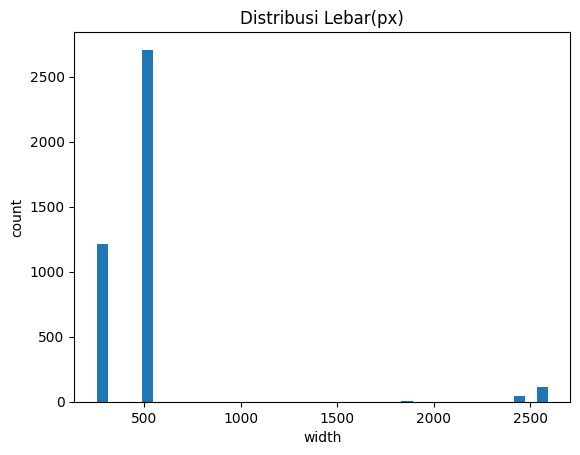

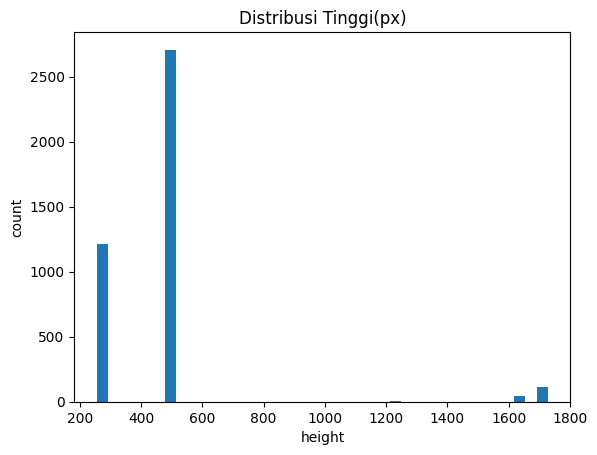

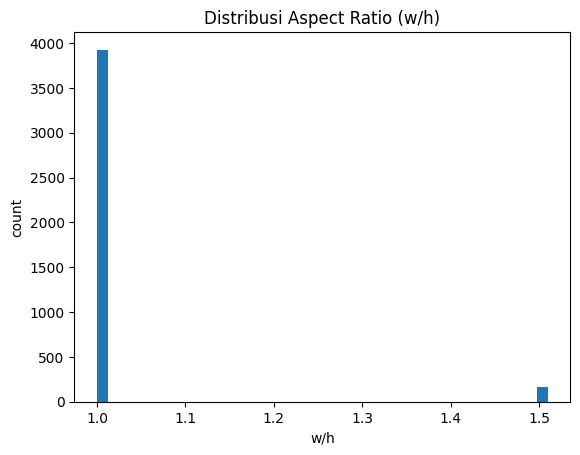

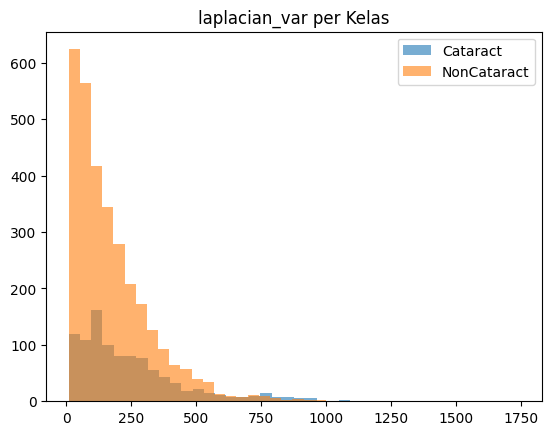

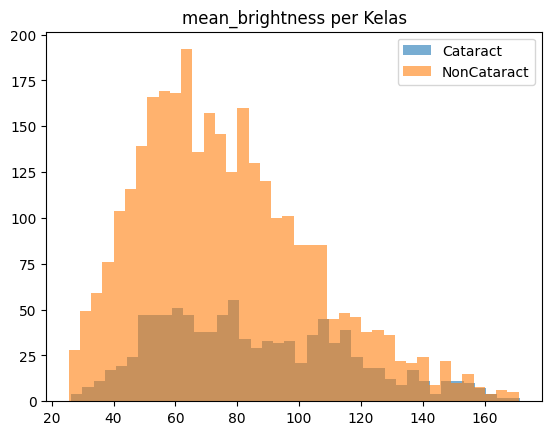

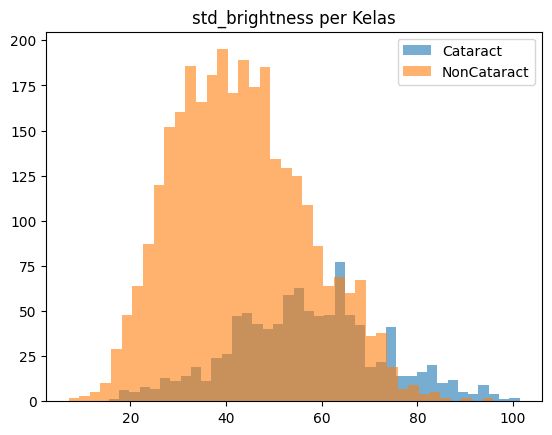

laplacian_var: U=1859362.0, p=2.908e-23, median(C)=187.067, median(N)=131.364
mean_brightness: U=1796696.5, p=1.244e-15, median(C)=80.177, median(N)=72.314
std_brightness: U=2287917.0, p=8.289e-119, median(C)=56.564, median(N)=42.304


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

df = pd.read_csv("/content/dataset/work/image_index_clean.csv")
df["binary_class"] = np.where(df["class"].str.lower()=="cataract", "Cataract", "NonCataract")

print("Class counts:\n", df["binary_class"].value_counts())

plt.figure(); plt.hist(df["width"].dropna(), bins = 40)
plt.title("Distribusi Lebar(px)"); plt.xlabel("width"); plt.ylabel("count"); plt.show

plt.figure(); plt.hist(df["height"].dropna(), bins = 40)
plt.title("Distribusi Tinggi(px)"); plt.xlabel("height"); plt.ylabel("count"); plt.show()

plt.figure(); plt.hist(df["aspect_ratio"].dropna(), bins = 40)
plt.title("Distribusi Aspect Ratio (w/h)"); plt.xlabel("w/h"); plt.xlabel("w/h"); plt.ylabel("count"); plt.show()

for col in ["laplacian_var","mean_brightness","std_brightness"]:
    plt.figure()
    for label in ["Cataract","NonCataract"]:
        vals = df.loc[df["binary_class"]==label, col].dropna()
        plt.hist(vals, bins=40, alpha=0.6, label=label)
    plt.title(f"{col} per Kelas"); plt.legend(); plt.show()

# 4) Uji statistik (opsional)
def test_diff(col):
    a = df.loc[df["binary_class"]=="Cataract", col].dropna()
    b = df.loc[df["binary_class"]=="NonCataract", col].dropna()
    if len(a)>20 and len(b)>20:
        stat, p = mannwhitneyu(a, b, alternative='two-sided')
        print(f"{col}: U={stat:.1f}, p={p:.3e}, median(C)={np.median(a):.3f}, median(N)={np.median(b):.3f}")
test_diff("laplacian_var")
test_diff("mean_brightness")
test_diff("std_brightness")

In [ ]:
import numpy as np, pandas as pd
from pathlib import Path
from tqdm import tqdm
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops
import cv2

TARGET_SIZE = (224,224)

def edge_density(gray):
    edges = cv2.Canny((gray*255).astype(np.uint8), 50, 150)
    return edges.mean()

def fft_high_freq_ratio(gray, frac=0.25):
    F = np.fft.fftshift(np.fft.fft2(gray))
    mag = np.abs(F)
    h,w = mag.shape
    cy,cx = h//2, w//2
    ry,rx = int(h*(1-frac)/2), int(w*(1-frac)/2)
    total = mag.sum()
    low = mag[cy-ry:cy+ry, cx-rx:cx+rx].sum()
    high = max(total - low, 1e-9)
    return float(high/total)

def extract_classic_features(path):
    img = imread(path)
    if img.ndim == 2:  # grayscale → RGB
        img = np.stack([img]*3, axis=-1)
    if img.shape[2] == 4:  # RGBA → RGB
        img = img[:,:,:3]
    img_res = resize(img, TARGET_SIZE, anti_aliasing=True)
    gray = rgb2gray(img_res)

    hog_feat = hog(gray, orientations=9, pixels_per_cell=(16,16),
                   cells_per_block=(2,2), block_norm="L2-Hys", feature_vector=True)

    lbp = local_binary_pattern(gray, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), density=True)

    glcm = graycomatrix((gray*255).astype(np.uint8),
                        distances=[1,2],
                        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                        levels=256, symmetric=True, normed=True)
    props = ["contrast","dissimilarity","homogeneity","ASM","energy","correlation"]
    glcm_feats = [graycoprops(glcm, p).mean() for p in props]

    r_mean,g_mean,b_mean = img_res.mean(axis=(0,1))
    r_std,g_std,b_std     = img_res.std(axis=(0,1))

    ed = edge_density(gray)
    hf = fft_high_freq_ratio(gray, frac=0.25)

    return np.concatenate([
        hog_feat, lbp_hist, glcm_feats,
        [r_mean,g_mean,b_mean, r_std,g_std,b_std],
        [ed, hf]
    ])

# Ekstrak untuk semua split
df_all = pd.concat([
    pd.read_csv("/content/dataset/work/index_train.csv"),
    pd.read_csv("/content/dataset/work/index_val.csv"),
    pd.read_csv("/content/dataset/work/index_test.csv"),
], ignore_index=True)

Xc, y, fp = [], [], []
for _, r in tqdm(df_all.iterrows(), total=len(df_all), desc="classic feats"):
    try:
        Xc.append(extract_classic_features(r["filepath"]))
        y.append(int(r["is_cataract"]))
        fp.append(r["filepath"])
    except Exception:
        pass

Xc = np.array(Xc)
np.save("/content/dataset/work/features_classic.npy", Xc)
pd.DataFrame({"filepath":fp, "is_cataract":y}).to_csv("/content/dataset/work/features_classic_index.csv", index=False)
print("Classic features shape:", Xc.shape)


Streaming output truncated to the last 5000 lines.
classic feats:  39%|███▉      | 1589/4088 [05:02<06:15,  6.65it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
classic feats:  39%|███▉      | 1590/4088 [05:02<06:21,  6.54it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
classic feats:  39%|███▉      | 1591/4088 [05:02<06:25,  6.47it/s]/usr/local/lib/python3.12/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `loca

Classic features shape: (4088, 6108)


In [ ]:
import numpy as np, pandas as pd, tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing import image

base = EfficientNetB0(weights="imagenet", include_top=False, pooling="avg", input_shape=(224,224,3))

def embed(path, target_size=(224,224)):
    img = image.load_img(path, target_size=target_size)
    x = image.img_to_array(img)[None,...]
    x = preprocess_input(x)
    v = base.predict(x, verbose=0)
    return v[0]

Xd, yd, fpd = [], [], []
for _, r in tqdm(df_all.iterrows(), total=len(df_all), desc="deep embed"):
    try:
        Xd.append(embed(r["filepath"]))
        yd.append(int(r["is_cataract"]))
        fpd.append(r["filepath"])
    except Exception:
        pass

Xd = np.array(Xd)
np.save(OUT_DIR/"features_deep_efficientnetB0.npy", Xd)
pd.DataFrame({"filepath":fpd, "is_cataract":yd}).to_csv(OUT_DIR/"features_deep_index.csv", index=False)
print("Deep embeddings shape:", Xd.shape)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


deep embed: 100%|██████████| 4088/4088 [11:16<00:00,  6.04it/s]

Deep embeddings shape: (4088, 1280)


In [ ]:
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split

OUT_DIR = "/content/dataset/work"

X = np.load(f"{OUT_DIR}/features_deep_efficientnetB0.npy")
df_index = pd.read_csv(f"{OUT_DIR}/features_deep_index.csv")
y = df_index["is_cataract"].values

print("Shape fitur:", X.shape, " | Label:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


Shape fitur: (4088, 1280)  | Label: (4088,)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

models = {
    "LogReg": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGBoost": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} → Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))


LogReg → Accuracy: 0.9609
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       619
           1       0.91      0.93      0.92       199

    accuracy                           0.96       818
   macro avg       0.94      0.95      0.95       818
weighted avg       0.96      0.96      0.96       818

RandomForest → Accuracy: 0.9535
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       619
           1       0.92      0.89      0.90       199

    accuracy                           0.95       818
   macro avg       0.94      0.93      0.94       818
weighted avg       0.95      0.95      0.95       818

XGBoost → Accuracy: 0.9499
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       619
           1       0.90      0.90      0.90       199

    accuracy                           0.95       818
   macro avg       0.93      0.93      0.93